### import the libraries

In [1]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern

## part1: prepare dataset(Don't make any changes in this cell.)

In [2]:
!curl -L -o /content/multiclassimagedatasetairplanecar.zip https://www.kaggle.com/api/v1/datasets/download/abtabm/multiclassimagedatasetairplanecar
!unzip -q /content/multiclassimagedatasetairplanecar.zip
# Paths
source_train = '/content/Dataset/train'
source_test = '/content/Dataset/test'
target_root = '/content/dataset'

classes_to_keep = ['airplanes', 'cars']

for class_name in classes_to_keep:
    os.makedirs(os.path.join(target_root, class_name), exist_ok=True)

def copy_images(src_folder, dst_folder, class_names):
    for class_name in class_names:
        src_class_dir = os.path.join(src_folder, class_name)
        dst_class_dir = os.path.join(dst_folder, class_name)
        for filename in os.listdir(src_class_dir):
            src_file = os.path.join(src_class_dir, filename)
            dst_file = os.path.join(dst_class_dir, filename)
            shutil.copy2(src_file, dst_file)

copy_images(source_train, target_root, classes_to_keep)
copy_images(source_test, target_root, classes_to_keep)

print("✅ Done prepare dataset!")
shutil.rmtree('/content/Dataset')
print("🧹 Original Dataset folder deleted!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  332M  100  332M    0     0  95.3M      0  0:00:03  0:00:03 --:--:--  112M
✅ Done prepare dataset!
🧹 Original Dataset folder deleted!


In [3]:
airplane_paths = glob.glob("/content/dataset/airplanes/*")
car_paths = glob.glob("/content/dataset/cars/*")
x_data , y_data = [], []
for img_path in airplane_paths + car_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "cars":
    y_data.append(0)
  else:
    y_data.append(1)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

## part2: implement compactness, eccenticity, solidity

In [5]:
def compatness(image):
  compactness_score = 0

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)

  area = cv2.contourArea(largest_contour)
  perimeter = cv2.arcLength(largest_contour, True)
  compactness_score = (area * 4 * np.pi) / (perimeter * perimeter)

  return compactness_score

In [16]:
def eccenticity(image):
  eccentricity_score = 0

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)

  if len(largest_contour) > 4:
    ellipse = cv2.fitEllipse(largest_contour)
    _, axes, _ = ellipse
    a, b = max(axes) / 2, min(axes) / 2  # 𝑀𝑎𝑗𝑜𝑟𝐴𝑥𝑖𝑠𝐿𝑒𝑛𝑔𝑡ℎ and 𝑀𝑖𝑛𝑜𝑟𝐴𝑥𝑖𝑠𝐿𝑒𝑛𝑔𝑡ℎ
    eccentricity_score = np.sqrt(1 - (b**2 / a**2))

  return eccentricity_score

In [7]:
def solidity(image):
  solidity_score = 0

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)

  hull = cv2.convexHull(largest_contour)
  hull_area = cv2.contourArea(hull)
  area = cv2.contourArea(largest_contour)
  solidity_score = area / hull_area


  return  solidity_score

In [ ]:
def LBP(image, numPoints, radius, eps=1e-7):
  hist = None

  # Compute LBP features
  lbp = local_binary_pattern(image, numPoints, radius, method="uniform")

  # Compute the histogram of LBP
  (hist, _) = np.histogram(lbp.ravel(), bins=numPoints+2)

  # Normalize the histogram
  hist = hist.astype("float")
  hist /= (hist.sum() + eps)

  return hist

## part3: Extract features and train the model

In [41]:
def get_featureMatrix(data):

  feature_matrix = []

  gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
  _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  compa = compatness(thresh)
  eccen = eccenticity(thresh)
  solid = solidity(thresh)
  lbp = LBP(gray, 8, 1)

  feature_matrix = np.concatenate([[compa], [eccen], [solid], lbp])


  return feature_matrix

#### define the model and train on train data

In [42]:
model = LinearSVC()
X = []
for x in x_data:
    X.append(get_featureMatrix(x))
X = np.array(X)
y = np.array(y_data)
model.fit(X, y)

LinearSVC()

#### test on test data and evaluate the model

In [ ]:
test = []
for t in x_test:
  test.append(get_featureMatrix(t))
y_pred = model.predict(test)
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")

accuracy: 0.8353808353808354


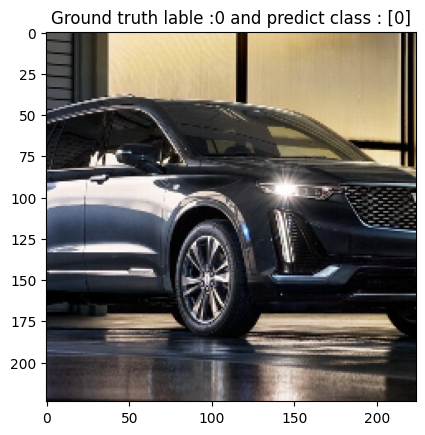

In [45]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = model.predict(get_featureMatrix(np.array(x_test[index])).reshape(1, -1))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()